# Face Detection Using Facenet Pytorch MTCNN


In this code, we utilize the facenet-pytorch library, which contains a trained model for detecting faces in images. Specifically, we make use of the MTCNN class, which takes an image as input and returns a list of box coordinates indicating the locations of the detected faces, along with a prediction percentage indicating the likelihood of each box containing a face. The accuracy of this model is very high, even capable of detecting small faces within an image. To focus on complete faces, we set a threshold of 0.80, although occasionally smaller or lower-quality faces may still be detected. The model is also known for its speed. 

This approach is straightforward as we rely on a pre-existing codebase, and the model itself was pretrained using the VGGFace2 and CASIA-Webface datasets.

Github: https://github.com/timesler/facenet-pytorch

Post cropping of the faces we will manually segregate the photos for the classication traning which is available in the Face Classifier Notebook.
        

In [7]:
#pip install facenet-pytorch

In [8]:
#Initialize variables
import os
#change this to your username if running on Jojie without admin permisison
os.environ['XDG_CACHE_HOME'] = '/home/msds2023/rbanquerigo/.cache' 

from torchvision import transforms as T
from facenet_pytorch import MTCNN
from PIL import Image

import torch
import random
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


In [9]:
def get_all_pics(path, sample_count):
    """
        This returns all the files within the specified path with .jpg or jpeg
        file format and checks the length of the fles against the sample_count
        that will be displayed.
        
        path - string, path where the images are located
        sample_count - int, how many samples will be displayed
        
        Return
        f_list - list of images with .jpg file type
        sample_count - int value of the samples
    """
    f_list = []
    for f in  os.listdir(path):
        if f.lower().endswith('.jpg') or f.lower().endswith('.jpeg'):
            f_list.append(f)
            
    if sample_count > len(f_list):
        sample_count = len(f_list)
        
    return f_list, sample_count


In [10]:
def plot_images(ax, img, f_name, rec=None):
    """
        This plots the faces rectangle patches and sets the image text,
        shows the image and removes the axis.
        
        ax - axes of the matplotlib
        img - image object 
        f_name - string value
        rec - the rectangle object this is only for the main photo
    """
    if rec is not None:
        ax.add_patch(rec)    
    ax.title.set_text(f_name)
    ax.imshow(img)
    ax.axis('off')


This function would be the core of this notebook and will be responsible for the detection, cropping, saving and sampling of the images we processed.

Was trying to modularized this further however the code is straightforward the comments below will help in explaining the flow

In [11]:
def detect_faces(path, save, model, pct, sample_count):
    """
        This function will detect, crop, save and sample images based 
        on the found .jpg files in the path.
        
        path - string, path where the images are located
        save - string, path where the cropped faces will be saved
        model - model object for the face detectiion
        pct - float, threshold on the face prediction
        sample_count - int, how many samples will be displayed
    """
    
    #Get all the files using get_all_pics
    files, sample_count = get_all_pics(path, sample_count)
    
    #Randomized which photos will be displayed
    rand = random.sample(range(0, len(files)), sample_count)
    
    #Initialize number of subplots for the main image
    fig, ax = plt.subplots(sample_count, 1, figsize=(20, 20))
    tot_face = 0
    start = time.time()
    print(f'Start Time: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
    
    #loop to process the images found in the path
    for idx, file in enumerate(files):
        
        #Open the image using PIL Image
        img = Image.open(os.path.join(path, file)).convert('RGB')
        
        #Detect faces using the MTCNN model with img as its input
        boxes, pred = model.detect(img)
        ax_count, i = 0, 0
        
        #Check if all cropped faces are within threshold
        for j in pred:
            if j is not None and j >= pct:
                ax_count += 1
                
        #Check if index of current image is the one to be sampled
        try:
            ind = rand.index(idx)
            fig2, ax2 = plt.subplots(1, ax_count, figsize=(5, 5))
        except ValueError:
            ind = None
            
        #Initialize number of subplots for the faces
        ax_main = ax[ind] if sample_count > 1 else ax
        if ax_count == 0:
            if ind is not None:
                plot_images(ax_main, img, file)
            continue
            
        #Process the detected faces
        for cnt, box in enumerate(zip(boxes, pred)):
            #Check if image is within threshold
            if box[1] >= pct:
                
                #Block of code to crop the face based on the coordinates
                x1, y1, x2, y2 = box[0]
                cropped_image = img.crop((x1, y1, x2, y2))
                crop_name = f'{file[:-4]}_crop_{i}.jpg'
                cropped_image.save(f'{save}/{crop_name}')
                tot_face += 1
                
                #Display image if its index isto be sampled
                if ind is not None:
                    width = x2 - x1
                    height = y2 - y1
                    rectangle = Rectangle((x1, y1), 
                                          width, 
                                          height, 
                                          fill=False, 
                                          ec='tab:green', 
                                          linewidth=3)        
                    plot_images(ax_main, img, file, rectangle)
                    ax_crop = ax2[i] if ax_count > 1 else ax2
                    plot_images(ax_crop, cropped_image, f'Face#{tot_face}')
          
                i += 1
    plt.show()       
    
    print(f'End: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
    print(f'Total Time {time.time() - start :.2F} seconds')
    print(f'Total Image Processed: {len(files)}')
    print(f'Total Face Cropped: {tot_face}')
   

Files are manually uploaded in the img/raw folder where the script is located.

Cropped faces will be written in img/crop and will be will be manually classified for training.

Threshold set to .80 as explained earlier with 5 samples in the sample code.

Start Time: 2023-05-11 05:38:08


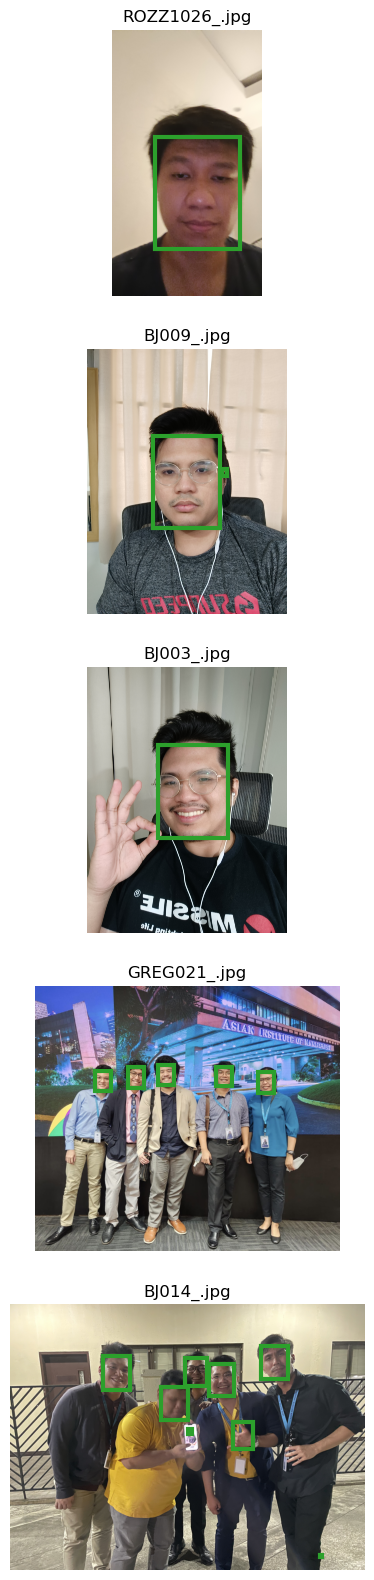

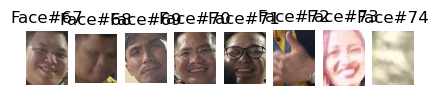

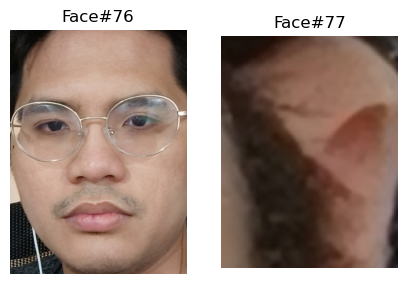

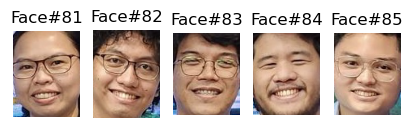

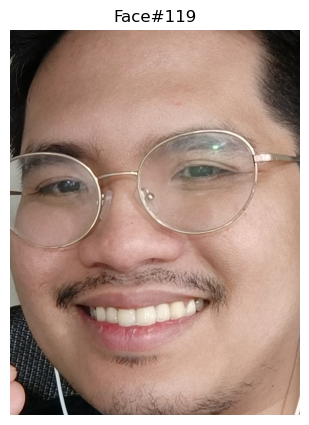

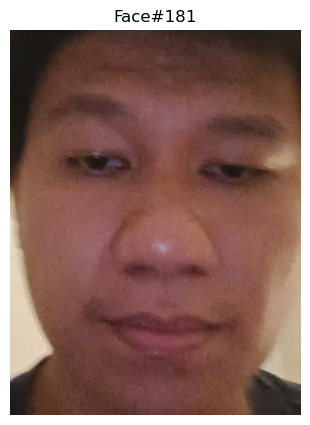

End: 2023-05-11 05:41:37
Total Time 209.39 seconds
Total Image Processed: 85
Total Face Cropped: 205


In [12]:
#Initialize values for the parameters
path = 'img/raw'
save = 'img/crop'
threshold = .80
samples = 5

#Set device to uitilize gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MTCNN model for face detection
mtcnn = MTCNN(device=device)

detect_faces(path, save, mtcnn, threshold, samples)

### Conclusion

If you try to re-run and check for more samples there will be some faces that will be detected that is very small like our id pictures or people in the background. Some photos from my test were not scanned properly since it was showing upright however the actual orientation is either updown or 90 degrees rotated, MTCNN can still scan it if we lower the threshold and needed to adjust the photos for it to be scanned. It was also able to detect face like images in example the starbucks logo it was scanned as a face given the threshold of 80% we have set. If we increased it to .99 or .999 it would only be able to return higher quality faces but this is something that we can adjust on specific requirements.